<a href="https://colab.research.google.com/github/KenObata/TISMIR_notebooks/blob/main/kaggle_dataset_extraction_en_10genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is to create kaggle dataset on genre classification for top10 genres.

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification?resource=download


### Preprocess: import files

In [ ]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.7 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [ ]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [ ]:
def analyze_genre_tag_df(df, target_column:int, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[target_column]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

In [ ]:
ZIP_FILE ="drive/MyDrive/music4all/kaggle.zip"

!unzip drive/MyDrive/music4all/kaggle.zip -d /content/

Archive:  drive/MyDrive/music4all/kaggle.zip
  inflating: /content/test.csv       
  inflating: /content/train.csv      


In [ ]:
df_train = pd.read_csv(os.path.join('/content/','train.csv'), header=0, sep=',')
df_test = pd.read_csv(os.path.join('/content/','test.csv'), header=0, sep=',')

In [ ]:
df_train

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
290178,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
290179,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
290180,celine dion,sorry for love,Pop,en,Forgive me for the things That I never said to...
290181,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


In [ ]:
df_test

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797
...,...,...,...,...,...,...
7930,too-little-too-late,2006,amanda-marshall,Rock,Tuesday night - 7:30\nI hear a voice on the te...,23453
7931,berserker,2007,aurora-borealis,Metal,Elite forces cloaked in fur un sensitive to pa...,2724
7932,natural-born-killaz,2010,dr-dre,Hip-Hop,[Dr. Dre]\nJourney with me\nInto the mind of a...,24147
7933,wide-awake,2011,chris-cornell,Rock,You can a look a hurricane right in the eye.\n...,4150


We need to use langdetect to detect language of df_test

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 60 kB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=a054e241a60d57d481ef5c118dab4a0ca938f4fd677f33213486f737414712d5
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
from langdetect import detect

df_test["Language"] = ""
for idx, row in df_test.loc[0:df_test.shape[0]].iterrows():
  language = detect(row["Lyrics"])
  df_test.loc[df_test.Track_id == row['Track_id'], "Language"] = language

Number of Language: 4


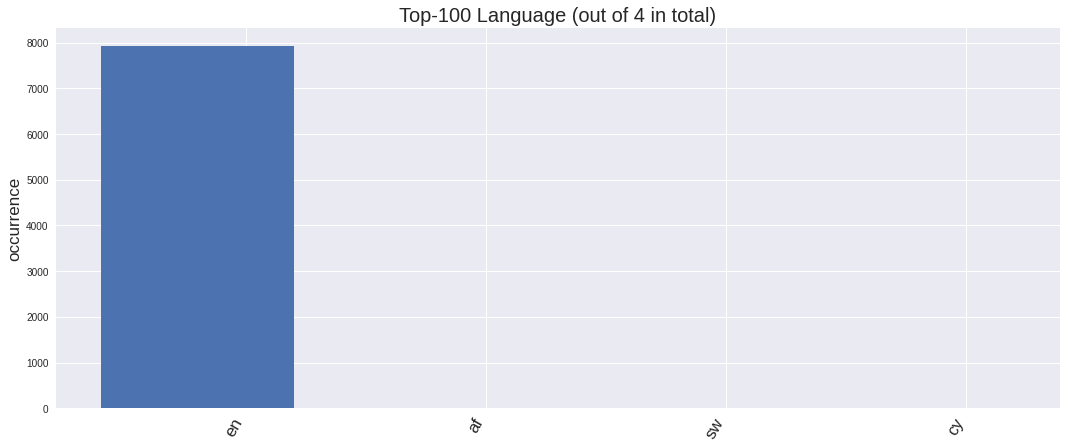

In [ ]:
#df_test.columns
language_counter = analyze_genre_tag_df(df_test, target_column=6)

In [ ]:
df_test_en = df_test[df_test["Language"]=="en"]
df_test_en

,Song,Song year,Artist,Genre,Lyrics,Track_id,Language
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294,en
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621,en
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301,en
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773,en
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797,en
...,...,...,...,...,...,...,...
7930,too-little-too-late,2006,amanda-marshall,Rock,Tuesday night - 7:30\nI hear a voice on the te...,23453,en
7931,berserker,2007,aurora-borealis,Metal,Elite forces cloaked in fur un sensitive to pa...,2724,en
7932,natural-born-killaz,2010,dr-dre,Hip-Hop,[Dr. Dre]\nJourney with me\nInto the mind of a...,24147,en
7933,wide-awake,2011,chris-cornell,Rock,You can a look a hurricane right in the eye.\n...,4150,en


### Data preparation

In [ ]:
df_train_en = df_train[df_train["Language"]=="en"]
df_train_en
#language_counter = analyze_genre_tag_df(df_train, target_column=3)

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
290178,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
290179,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
290180,celine dion,sorry for love,Pop,en,Forgive me for the things That I never said to...
290181,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


Concatenate train and test. We want to do stratified K split on our own.

In [ ]:
df_en = pd.concat([df_test_en[["Genre", "Lyrics"]],df_train_en[["Genre", "Lyrics"]]],axis=0)
df_en = df_en.reset_index(drop=True)
df_en

,Genre,Lyrics
0,Hip-Hop,Most folks spend their days daydreaming of fin...
1,Indie,Take your cold hands and put them on my face\n...
2,Metal,Are you ready it's time for war\nWe'll break d...
3,Pop,You ask me why I change the color of my hair\n...
4,Hip-Hop,Do you believe in magic in a young girl's hear...
...,...,...
258123,R&B,I'm the best friend he's got I'd give him the ...
258124,Pop,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
258125,Pop,Forgive me for the things That I never said to...
258126,Indie,The day they found a cure for AIDS The day the...


Number of Genre: 10


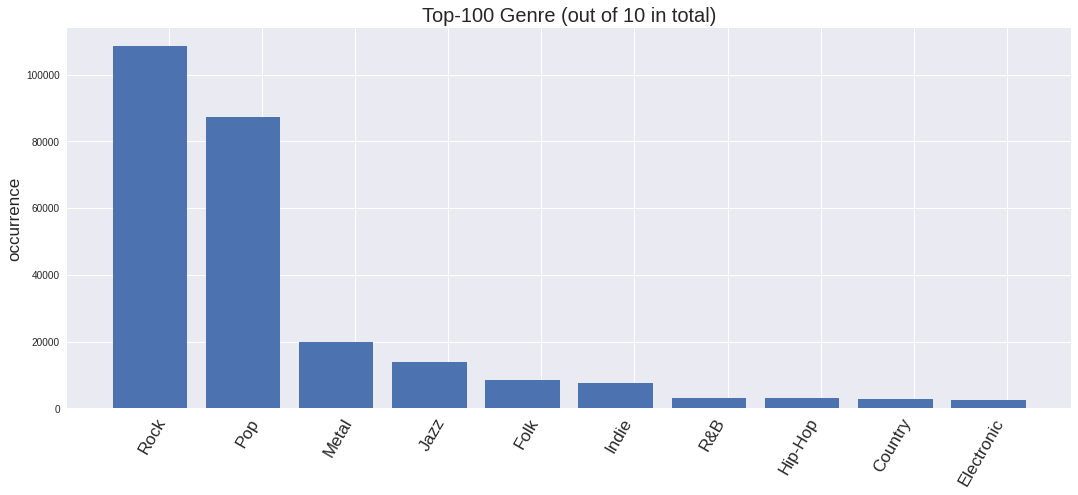

In [ ]:
#df_train.columns[2]
genre_counter_en = analyze_genre_tag_df(df_en, target_column=0)

In [ ]:
genre_counter = sorted(genre_counter_en.items(), key=lambda item: item[1], reverse = True)
genre_counter_top = genre_counter[:10]

In [ ]:
genre_counter_top

[('Rock', 108555),
 ('Pop', 87407),
 ('Metal', 19943),
 ('Jazz', 13974),
 ('Folk', 8664),
 ('Indie', 7750),
 ('R&B', 3273),
 ('Hip-Hop', 3198),
 ('Country', 2700),
 ('Electronic', 2664)]

In [ ]:
genre_counter_top_list = [genre for genre, count in genre_counter_top ]
genre_counter_top_list

['Rock',
 'Pop',
 'Metal',
 'Jazz',
 'Folk',
 'Indie',
 'R&B',
 'Hip-Hop',
 'Country',
 'Electronic']

#### Gensim tutorial (just get an idea)
We start off by using the Gensim's implementation of the algorithm to provide a high-level intuition

In [ ]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
#%load_ext watermark
#%load_ext autoreload
#%autoreload 2
#%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
from time import time
from joblib import cpu_count
from collections import Counter
from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups

#%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,sklearn,gensim

In [ ]:
#1.get tokens
sentences = [doc.strip().split() for doc in df_genre_by_lang["lyric"]]
workers = cpu_count()
word2vec = Word2Vec(sentences, workers=workers)

word_vectors = pd.DataFrame(word2vec.wv.vectors, index=word2vec.wv.index2word)

print('word vector dimension: ', word_vectors.shape)
word_vectors.head()

word vector dimension:  (19638, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
i,-2.376211,2.409590,-0.858046,0.876853,-1.828595,-2.001027,0.785672,-0.223030,0.817970,-1.105674,...,-0.964525,2.459497,-0.030625,1.159744,0.382707,1.877144,-0.378518,1.159576,1.252017,0.799860
you,-2.083040,2.770387,-0.424679,1.096247,-2.397687,-2.525117,1.062848,0.497500,0.751802,-0.723402,...,-0.871156,2.013160,-0.133436,1.436425,-0.007446,1.085023,-0.568981,2.447391,1.163083,0.898891
the,-0.413685,-0.223014,-0.427339,1.373779,-1.962237,-1.000596,1.134558,-0.032298,-2.039423,1.075204,...,0.543838,0.056569,-0.691498,0.804162,0.645243,1.011362,-0.714649,1.508362,0.739983,0.369040
and,-0.626104,0.537895,0.730908,0.650489,-0.030223,-1.451856,0.513093,0.160804,-0.406841,0.039868,...,-1.358424,-0.459215,-0.293320,1.081964,0.034645,0.491840,-0.080239,-0.121153,0.034893,0.298263
to,-0.027456,3.686999,1.018549,-0.720617,-0.184807,-3.579421,0.078966,0.806777,0.875923,-1.629473,...,-0.600925,0.535842,0.153353,2.182342,-0.691965,0.819038,-0.837098,1.794350,-0.775012,1.566848


Note to myself: how to change dimensionality and how much does it matter?
The lack of experiments for embedding size implies that the performance is not very sensitive to this parameter. But the number of dimensions can affect training time.

https://datascience.stackexchange.com/questions/51404/word2vec-how-to-choose-the-embedding-size-parameter


In [ ]:
word2vec.wv.most_similar(positive=['love'], topn=5)

[('you', 0.6292002201080322),
 ('oh', 0.6131366491317749),
 ('babi', 0.6077142953872681),
 ('me', 0.5805143117904663),
 ('know', 0.579627513885498)]

There is a window size hyperparameter to the algorithm that quantifies the word "nearby". A typical window size might be 5, meaning 5 words behind and 5 words ahead (10 in total).

In [ ]:
word2vec.corpus_total_words

13265068

In [ ]:
vocab = word2vec.wv.vocab
index2word = word2vec.wv.index2word
print(len(vocab))
print(len(index2word))

19638
19638


In [ ]:
pd.set_option('display.max_rows', word_vectors.shape[1]+1)
word_vectors

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
i,-2.376211,2.409590,-0.858046,0.876853,-1.828595,-2.001027,0.785672,-0.223030,0.817970,-1.105674,...,-0.964525,2.459497,-0.030625,1.159744,0.382707,1.877144,-0.378518,1.159576,1.252017,0.799860
you,-2.083040,2.770387,-0.424679,1.096247,-2.397687,-2.525117,1.062848,0.497500,0.751802,-0.723402,...,-0.871156,2.013160,-0.133436,1.436425,-0.007446,1.085023,-0.568981,2.447391,1.163083,0.898891
the,-0.413685,-0.223014,-0.427339,1.373779,-1.962237,-1.000596,1.134558,-0.032298,-2.039423,1.075204,...,0.543838,0.056569,-0.691498,0.804162,0.645243,1.011362,-0.714649,1.508362,0.739983,0.369040
and,-0.626104,0.537895,0.730908,0.650489,-0.030223,-1.451856,0.513093,0.160804,-0.406841,0.039868,...,-1.358424,-0.459215,-0.293320,1.081964,0.034645,0.491840,-0.080239,-0.121153,0.034893,0.298263
to,-0.027456,3.686999,1.018549,-0.720617,-0.184807,-3.579421,0.078966,0.806777,0.875923,-1.629473,...,-0.600925,0.535842,0.153353,2.182342,-0.691965,0.819038,-0.837098,1.794350,-0.775012,1.566848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sk,0.000999,0.149825,0.126939,0.075687,-0.004902,-0.024383,-0.141062,0.110374,-0.024840,0.060382,...,0.226615,0.047369,0.058588,0.130012,-0.061040,0.066213,0.023118,0.087082,-0.002162,-0.116514
inf,0.146106,-0.037186,0.027272,-0.032783,0.014985,0.175157,0.075362,0.113695,-0.147926,0.080529,...,0.161023,0.083768,-0.008160,-0.063728,-0.158651,-0.212929,0.085444,0.017026,-0.052897,0.099011
tra,0.041593,0.023325,0.071489,-0.026207,-0.082581,0.090819,0.041419,0.096232,0.008583,-0.016105,...,0.026591,0.117291,-0.082786,-0.005228,-0.073462,-0.102460,0.157974,0.077027,-0.043822,0.165361
voil,0.054040,-0.049217,-0.026269,-0.018589,0.056856,0.142391,0.036848,0.076625,-0.164106,0.017531,...,0.029511,0.003912,0.023311,-0.027381,-0.074113,-0.065925,0.107244,-0.018061,-0.006940,0.082082
